In [ ]:
from google.colab import drive
import os
from pathlib import Path

# 1. 드라이브 마운트
if not os.path.exists('/content/drive'):
    print("📂 구글 드라이브 연결 중...")
    drive.mount('/content/drive')
else:
  print("✅ 이미 연결되어 있습니다.")

# 2. 경로 설정 (사용자 경로 확인)
# 원본 데이터 경로
SOURCE_DATA_PATH = Path('/content/drive/MyDrive/LIKE_LION/2nd_project(segmentation)/plantseg_tomato')

# 로컬 복사 경로 (속도 향상용)
RAW_DATA_DIR = Path('/content/raw_data')
MMSEG_DATA_DIR = Path('/content/mmseg_data')

print(f"📍 원본 경로 확인: {SOURCE_DATA_PATH}")

✅ 이미 연결되어 있습니다.
📍 원본 경로 확인: /content/drive/MyDrive/LIKE_LION/2nd_project(segmentation)/plantseg_tomato


#Step 1: 환경 설정 (MMSegmentation 설치 in conda)

In [ ]:
%%bash
# 에러가 나면 즉시 멈춤
set -e

echo "========================================================================"
echo "🖥️ 시스템 및 GPU 확인"
echo "========================================================================"
nvidia-smi --query-gpu=name,memory.total,driver_version --format=csv,noheader
echo "------------------------------------------------------------------------"

# 1. Miniconda 설치
echo "📦 Miniconda + UV 설치"
if [ ! -d "/content/conda" ]; then
    wget -q https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh -O /tmp/miniconda.sh
    bash /tmp/miniconda.sh -b -p /content/conda > /dev/null 2>&1
    rm /tmp/miniconda.sh
fi

# 2. UV 설치
if [ ! -f "/content/conda/bin/uv" ]; then
    /content/conda/bin/pip install uv -q
fi
echo "✅ Miniconda & UV 설치 완료"

# 3. Python 3.10 가상환경 생성 (OpenMMLab 최적 버전)
echo "🐍 Python 3.10 conda 환경 생성"

# 콘다 활성화
source /content/conda/bin/activate

# ==================================================================
# 🚑 [핵심 수정] Anaconda Terms of Service (ToS) 강제 동의
# ==================================================================
echo "📜 Anaconda 약관 동의 처리 중..."
conda config --set always_yes true
# 에러 로그에서 요구한 약관 동의 명령어를 실행합니다.
conda tos accept --override-channels --channel https://repo.anaconda.com/pkgs/main > /dev/null 2>&1 || true
conda tos accept --override-channels --channel https://repo.anaconda.com/pkgs/r > /dev/null 2>&1 || true

# 채널 설정 (conda-forge 우선)
conda config --add channels conda-forge 2>/dev/null || true
conda config --set channel_priority flexible 2>/dev/null || true

# 가상환경 생성
if [ ! -d "/content/conda/envs/openmmlab" ]; then
    # conda-forge 채널을 명시하여 메인 채널 의존성을 줄임
    conda create -n openmmlab python=3.10 -c conda-forge -y -q
fi
echo "✅ 환경 생성 완료 (Python 3.10)"

# 4. PyTorch 2.1.2 + CUDA 11.8 (안정성 최고 조합)
echo "🔥 PyTorch 2.1.2 + CUDA 11.8 설치"
PY=/content/conda/envs/openmmlab/bin/python
UV=/content/conda/bin/uv

$UV pip install torch==2.1.2 torchvision==0.16.2 \
    --index-url https://download.pytorch.org/whl/cu118 \
    --python $PY -q
echo "✅ PyTorch 설치 완료"

# 5. OpenMMLab 스택 설치 (MMSegmentation 전용)
echo "📦 OpenMMLab (MMCV, MMEngine, MMSegmentation) 설치"

# MMCV 설치
$UV pip install mmcv==2.1.0 \
    -f https://download.openmmlab.com/mmcv/dist/cu118/torch2.1/index.html \
    --python $PY -q

# MMEngine 설치
$UV pip install mmengine==0.10.3 --python $PY -q

# SegNeXt용 추가 라이브러리
$UV pip install ftfy regex timm --python $PY -q

# MMSegmentation 소스 설치
if [ ! -d "/content/mmsegmentation" ]; then
    git clone -b main https://github.com/open-mmlab/mmsegmentation.git /content/mmsegmentation
fi

cd /content/mmsegmentation
$UV pip install -e . --python $PY -q

echo "🎉 모든 설치 완료! 환경이 완벽하게 격리되었습니다."

🖥️ 시스템 및 GPU 확인
NVIDIA A100-SXM4-80GB, 81920 MiB, 550.54.15
------------------------------------------------------------------------
📦 Miniconda + UV 설치
✅ Miniconda & UV 설치 완료
🐍 Python 3.10 conda 환경 생성
📜 Anaconda 약관 동의 처리 중...
Jupyter detected...
2 channel Terms of Service accepted
Retrieving notices: ...working... done
Channels:
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: ...working... done

## Package Plan ##

  environment location: /content/conda/envs/openmmlab

  added / updated specs:
    - python=3.10


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _libgcc_mutex-0.1          |      conda_forge           3 KB  conda-forge
    _openmp_mutex-4.5          |            2_gnu          23 KB  conda-forge
    bzip2-1.0.8                |       hda65f42_8         254 KB  conda-forge
    ca-certificates-2026.1.4   |       hbd8a1cb_0         143 KB  conda-forge
    i

Cloning into '/content/mmsegmentation'...


In [ ]:
import sys
import os

# 1. Conda 가상환경 경로 정의 (우리가 설치한 openmmlab 환경)
CONDA_ENV = "/content/conda/envs/openmmlab"
BIN_DIR = os.path.join(CONDA_ENV, "bin")

# 2. 파이썬 실행 파일 절대 경로 (이 변수를 !{py}에서 사용하게 됩니다 ⭐️)
py = os.path.join(BIN_DIR, "python")

# 3. 시스템 PATH에 추가 (현재 세션용)
os.environ["PATH"] = f"{BIN_DIR}:{os.environ['PATH']}"

# 4. 파이썬 라이브러리 경로(sys.path) 추가
# (이걸 해야 주피터 노트북 안에서 'import mmcv' 등이 에러 없이 작동합니다)
site_packages = os.path.join(CONDA_ENV, "lib", "python3.10", "site-packages")
if site_packages not in sys.path:
    sys.path.insert(0, site_packages)

print(f"✅ 환경 변수 설정 완료!")
print(f"👉 실행 명령어 변수(py): {py}")
print(f"👉 라이브러리 경로: {site_packages}")

✅ 환경 변수 설정 완료!
👉 실행 명령어 변수(py): /content/conda/envs/openmmlab/bin/python
👉 라이브러리 경로: /content/conda/envs/openmmlab/lib/python3.10/site-packages


In [ ]:
# NumPy 버전을 2.0 미만으로 강제 다운그레이드
print("🔧 NumPy 호환성 패치 중...")
!{py} -m pip install "numpy<2.0"

print("✅ NumPy 다운그레이드 완료!")

🔧 NumPy 호환성 패치 중...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 47.1 MB/s  0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.13.0.90 requires numpy>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
✅ NumPy 다운그레이드 완료!


In [ ]:
import sys
import os

# 1. Conda 가상환경 경로 정의 (우리가 설치한 openmmlab 환경)
CONDA_ENV = "/content/conda/envs/openmmlab"
BIN_DIR = os.path.join(CONDA_ENV, "bin")

# 2. 파이썬 실행 파일 절대 경로 (이 변수를 계속 쓸 겁니다 ⭐️)
py = os.path.join(BIN_DIR, "python")

# 3. 시스템 PATH에 추가 (현재 세션용)
os.environ["PATH"] = f"{BIN_DIR}:{os.environ['PATH']}"

# 4. 파이썬 라이브러리 경로(sys.path) 추가
# (이걸 해야 주피터 노트북 안에서 'import mmcv' 등이 됨)
site_packages = os.path.join(CONDA_ENV, "lib", "python3.10", "site-packages")
if site_packages not in sys.path:
    sys.path.insert(0, site_packages)

print(f"✅ 경로 설정 완료!")
print(f"👉 실행 명령어 변수: {py}")
print(f"👉 라이브러리 경로: {site_packages}")

✅ 경로 설정 완료!
👉 실행 명령어 변수: /content/conda/envs/openmmlab/bin/python
👉 라이브러리 경로: /content/conda/envs/openmmlab/lib/python3.10/site-packages


#전처리 및 폴더정리

In [ ]:
import shutil
import json
import cv2
import numpy as np
import os
import glob
from pathlib import Path
from tqdm import tqdm

# 경로 설정
DRIVE_PATH = Path('/content/drive/MyDrive/LIKE_LION/2nd_project(segmentation)/plantseg_tomato')
RAW_DATA_DIR = Path('/content/raw_data')
MMSEG_DATA_DIR = Path('/content/mmseg_data')

# ================= 1. 데이터 복사 =================
# 이미 복사가 되어 있다면 건너뛰어 시간 절약 (원하면 주석 해제하여 강제 재복사 가능)
if not RAW_DATA_DIR.exists():
    print(f"🚀 [1단계] 데이터를 코랩 로컬로 복사합니다...")
    shutil.copytree(DRIVE_PATH, RAW_DATA_DIR)
else:
    print(f"🚀 [1단계] 데이터가 이미 존재하므로 복사를 건너뜁니다.")

# ================= 2. 클래스 매핑 수정 (로그 기반 완벽 매칭) =================
# 실제 JSON에 적힌 띄어쓰기 포함된 이름으로 수정했습니다.
CLASS_MAP = {
    'tomato bacterial leaf spot': 1,
    'tomato early blight': 2,
    'tomato late blight': 3,
    'tomato leaf mold': 4,
    'tomato septoria leaf spot': 5,
    'tomato yellow leaf curl virus': 6,
    'tomato mosaic virus': 7,
}

# ================= 3. 변환 함수 =================
def convert_to_mmseg(json_path, src_img_dir, output_img_dir, output_mask_dir):
    try:
        with open(json_path, 'r') as f: data = json.load(f)

        # 이미지 파일 찾기
        file_stem = json_path.stem
        img_file = None
        for ext in ['.jpg', '.JPG', '.png', '.PNG', '.jpeg']:
            temp_path = src_img_dir / (file_stem + ext)
            if temp_path.exists():
                img_file = temp_path
                break

        if img_file is None: return False

        # 마스크 생성
        mask = np.zeros((data['imageHeight'], data['imageWidth']), dtype=np.uint8)
        label_found = False

        for shape in data['shapes']:
            raw_label = shape['label'].lower().strip() # 소문자 변환 + 양옆 공백 제거
            cid = 0

            # 정확한 매칭을 위해 수정
            for keyword, idx in CLASS_MAP.items():
                if keyword in raw_label:
                    cid = idx
                    break

            if cid > 0:
                label_found = True
                pts = np.array(shape['points'], dtype=np.int32)
                cv2.fillPoly(mask, [pts], cid)

        # 저장
        if label_found:
            shutil.copy(img_file, output_img_dir / f"{file_stem}.jpg")
            cv2.imwrite(str(output_mask_dir / f"{file_stem}.png"), mask)
            return True

    except Exception as e:
        # print(f"Error: {e}")
        return False
    return False

# ================= 4. 전체 실행 =================
print("\n🚀 [2단계] SegNeXt 형식으로 변환 시작...")

if MMSEG_DATA_DIR.exists(): shutil.rmtree(MMSEG_DATA_DIR)

for split in ['train', 'val']:
    (MMSEG_DATA_DIR / 'images' / split).mkdir(parents=True, exist_ok=True)
    (MMSEG_DATA_DIR / 'annotations' / split).mkdir(parents=True, exist_ok=True)

SPLIT_MAP = {'train': 'train', 'test': 'val'}

processed_count = 0
total_files = 0

for src_split, target_split in SPLIT_MAP.items():
    src_json_dir = RAW_DATA_DIR / 'json' / src_split
    src_img_dir = RAW_DATA_DIR / 'images' / src_split

    if not src_json_dir.exists(): continue

    print(f"   📂 처리 중: {src_split} -> {target_split}")
    json_files = list(src_json_dir.glob('*.json'))
    total_files += len(json_files)

    for json_file in tqdm(json_files, desc=f"{src_split}"):
        if convert_to_mmseg(json_file, src_img_dir,
                          MMSEG_DATA_DIR / 'images' / target_split,
                          MMSEG_DATA_DIR / 'annotations' / target_split):
            processed_count += 1

print(f"\n✨ 변환 완료! (총 {processed_count}/{total_files}개 성공)")

🚀 [1단계] 데이터가 이미 존재하므로 복사를 건너뜁니다.

🚀 [2단계] SegNeXt 형식으로 변환 시작...
   📂 처리 중: train -> train


train: 100%|██████████| 720/720 [00:02<00:00, 265.19it/s]


   📂 처리 중: test -> val


test: 100%|██████████| 181/181 [00:00<00:00, 270.09it/s]


✨ 변환 완료! (총 900/901개 성공)


In [ ]:
import json
from pathlib import Path

# 경로 설정
RAW_DATA_DIR = Path('/content/raw_data')
MMSEG_DATA_DIR = Path('/content/mmseg_data')

print("🕵️ 실패한 1개의 파일을 찾습니다...\n")

# 1. 원본 파일 리스트 (이름만 추출)
all_stems = set()
json_path_map = {} # 나중에 파일을 열어보기 위해 경로 저장

for split in ['train', 'val']: # 원본 폴더명 (train, test)에 맞춰 수정
    # 원본 폴더가 train/test로 되어있으니 매핑 필요
    raw_split = 'train' if split == 'train' else 'test'

    json_dir = RAW_DATA_DIR / 'json' / raw_split
    for p in json_dir.glob('*.json'):
        all_stems.add(p.stem)
        json_path_map[p.stem] = p

# 2. 변환 성공한 파일 리스트
success_stems = set()
for p in MMSEG_DATA_DIR.rglob('*.png'): # 마스크 파일 기준
    success_stems.add(p.stem)

# 3. 차집합 (실패한 파일 찾기)
failed_files = all_stems - success_stems

if not failed_files:
    print("🎉 어라? 모든 파일이 변환되었습니다. (개수 카운트 오류일 수 있음)")
else:
    print(f"🚨 총 {len(failed_files)}개의 파일이 변환되지 않았습니다.")

    for stem in failed_files:
        json_file = json_path_map[stem]
        print(f"\n❌ 실패한 파일명: {json_file.name}")

        # 내용 확인
        try:
            with open(json_file, 'r') as f:
                data = json.load(f)

            print("   👀 파일 내부 라벨 확인:")
            labels = [shape['label'] for shape in data['shapes']]
            for lbl in labels:
                print(f"      - {lbl}")

            print("\n   👉 원인 추정: 위 라벨이 CLASS_MAP에 정의된 철자와 미세하게 다를 수 있습니다.")

        except Exception as e:
            print(f"   ⚠️ 파일 읽기 에러: {e}")

print("\n------------------------------")
print("💡 팁: 1개 정도는 학습에 영향이 없으므로 무시하고 진행하셔도 됩니다.")

🕵️ 실패한 1개의 파일을 찾습니다...

🚨 총 1개의 파일이 변환되지 않았습니다.

❌ 실패한 파일명: tomato_leaf_mold_google_0110.json
   👀 파일 내부 라벨 확인:

   👉 원인 추정: 위 라벨이 CLASS_MAP에 정의된 철자와 미세하게 다를 수 있습니다.

------------------------------
💡 팁: 1개 정도는 학습에 영향이 없으므로 무시하고 진행하셔도 됩니다.


#제대로 변환이 완료되었는지 확인하기

👀 마스크 파일 안에 들어있는 값들: [0 1]


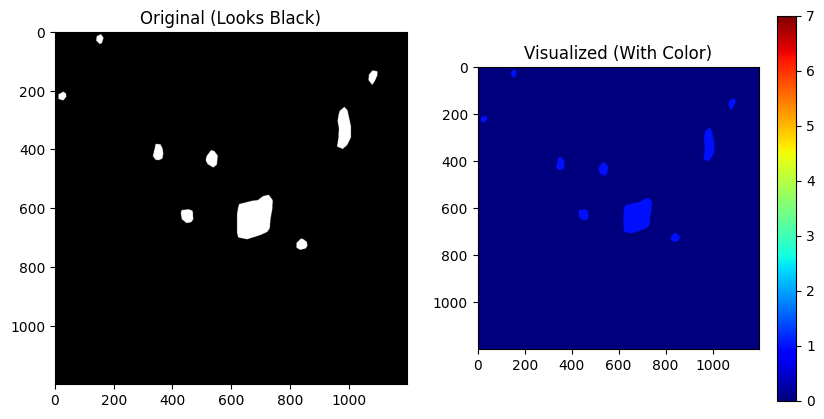

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

# 확인하고 싶은 파일 경로 (방금 변환된 폴더에서 하나 가져옴)
# (경로는 실제 존재하는 파일명으로 아무거나 지정하시면 됩니다)
mask_path = Path('/content/mmseg_data/annotations/train/tomato_bacterial_leaf_spot_147.png')

if mask_path.exists():
    # 1. 이미지 불러오기
    mask = np.array(Image.open(mask_path))

    # 2. 안에 들어있는 숫자(라벨) 확인
    unique_values = np.unique(mask)
    print(f"👀 마스크 파일 안에 들어있는 값들: {unique_values}")

    # 3. 눈에 보이게 색칠해서 출력하기
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Original (Looks Black)")
    plt.imshow(mask, cmap='gray') # 그냥 보면 검은색

    plt.subplot(1, 2, 2)
    plt.title("Visualized (With Color)")
    plt.imshow(mask, cmap='jet', vmin=0, vmax=7) # 강제로 색을 입힘
    plt.colorbar()

    plt.show()
else:
    print(f"⚠️ 파일을 찾을 수 없습니다: {mask_path}")
    print("경로를 확인하거나 다른 파일명을 넣어주세요.")

In [ ]:
import json
from pathlib import Path

# 경로 설정
RAW_DATA_DIR = Path('/content/raw_data')
MMSEG_DATA_DIR = Path('/content/mmseg_data')

print("🕵️ 실패한 1개의 파일을 찾습니다...\n")

# 1. 원본 파일 리스트 (이름만 추출)
all_stems = set()
json_path_map = {} # 나중에 파일을 열어보기 위해 경로 저장

for split in ['train', 'val']: # 원본 폴더명 (train, test)에 맞춰 수정
    # 원본 폴더가 train/test로 되어있으니 매핑 필요
    raw_split = 'train' if split == 'train' else 'test'

    json_dir = RAW_DATA_DIR / 'json' / raw_split
    for p in json_dir.glob('*.json'):
        all_stems.add(p.stem)
        json_path_map[p.stem] = p

# 2. 변환 성공한 파일 리스트
success_stems = set()
for p in MMSEG_DATA_DIR.rglob('*.png'): # 마스크 파일 기준
    success_stems.add(p.stem)

# 3. 차집합 (실패한 파일 찾기)
failed_files = all_stems - success_stems

if not failed_files:
    print("🎉 어라? 모든 파일이 변환되었습니다. (개수 카운트 오류일 수 있음)")
else:
    print(f"🚨 총 {len(failed_files)}개의 파일이 변환되지 않았습니다.")

    for stem in failed_files:
        json_file = json_path_map[stem]
        print(f"\n❌ 실패한 파일명: {json_file.name}")

        # 내용 확인
        try:
            with open(json_file, 'r') as f:
                data = json.load(f)

            print("   👀 파일 내부 라벨 확인:")
            labels = [shape['label'] for shape in data['shapes']]
            for lbl in labels:
                print(f"      - {lbl}")

            print("\n   👉 원인 추정: 위 라벨이 CLASS_MAP에 정의된 철자와 미세하게 다를 수 있습니다.")

        except Exception as e:
            print(f"   ⚠️ 파일 읽기 에러: {e}")

print("\n------------------------------")
print("💡 팁: 1개 정도는 학습에 영향이 없으므로 무시하고 진행하셔도 됩니다.")

🕵️ 실패한 1개의 파일을 찾습니다...

🚨 총 1개의 파일이 변환되지 않았습니다.

❌ 실패한 파일명: tomato_leaf_mold_google_0110.json
   👀 파일 내부 라벨 확인:

   👉 원인 추정: 위 라벨이 CLASS_MAP에 정의된 철자와 미세하게 다를 수 있습니다.

------------------------------
💡 팁: 1개 정도는 학습에 영향이 없으므로 무시하고 진행하셔도 됩니다.


#3️⃣ [다운로드] Pre-trained 모델

In [ ]:
# openmim 설치 (이게 없어서 에러가 났던 겁니다)
!{py} -m pip install -U openmim

print("✅ OpenMIM (mim) 설치 완료! 이제 다운로드가 될 겁니다.")

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.1/953.1 kB 41.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 85.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 100.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 52.4 MB/s  0:00:00
  Created wheel for oss2: filename=oss2-2.17.0-py3-none-any.whl size=112465 sha256=f2b5a21937c4a2ac3c330026b2edbccfa3405b1fb14ee1ac3c0a306070f7ca9b
  Stored in directory: /root/.cache/pip/wheels/87/04/7b/7e61b8157fdf211c5131375240d0d86ca82e2a88ead9672c88
  Created wheel for aliyun-python-sdk

#config 파일 생성

In [ ]:
import os

# 드라이브 경로 (기존 경로 그대로 사용)
drive_ckpt_path = '/content/drive/MyDrive/LIKE_LION/2nd_project(segmentation)/segnext_mscan-l_1x16_512x512_adamw_160k_ade20k_20230209_172055-19b14b63.pth'

# Config 내용 작성
config_content = f"""
# 1. 원본 레시피 상속
_base_ = ['/content/mmsegmentation/configs/segnext/segnext_mscan-l_1xb16-adamw-160k_ade20k-512x512.py']

# 2. [핵심 수정] 가중치 로드 경로는 'model' 밖, 최상위에 있어야 함!
load_from = '{drive_ckpt_path}'

# 3. 모델 설정 (load_from 제거됨)
model = dict(
    decode_head=dict(num_classes=8),
    # 여기 있던 load_from을 밖으로 뺐습니다.
)

# 4. 데이터셋 설정
dataset_type = 'BaseSegDataset'
data_root = '/content/mmseg_data'
crop_size = (1024, 1024)

train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),

    # 1. 6000px 괴물들을 진정시킴 (비율 유지, 긴 변이 2048 넘지 않게)
    dict(type='Resize', scale=(2048, 1024), keep_ratio=True),

    # 2. 70px 꼬맹이들을 위해 패딩 미리 준비 (최소 1024x1024 확보)
    # 이미지가 1024보다 크면? 아무 일도 안 일어남 (Pass)
    # 이미지가 1024보다 작으면? 검은색으로 채워서 1024 만듦
    dict(type='Pad', size=(1024, 1024), pad_val=dict(img=0, seg=255)),

    # 3. 모든 이미지가 최소 1024x1024가 되었으므로,
    # 여기서 1024x1024 크기로 "랜덤하게 잘라냄(Crop)"
    # 큰 이미지(ex: 1200x1024)는 일부가 잘리고, 딱 맞는 이미지는 그대로 통과됨.
    dict(type='RandomCrop', crop_size=(1024, 1024), cat_max_ratio=0.75),

    dict(type='RandomFlip', prob=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='PackSegInputs')
]

test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(2048, 1024), keep_ratio=True),
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]

train_dataloader = dict(
    batch_size=4,
    num_workers=4,
    dataset=dict(
        type=dataset_type,
        data_root=data_root,
        data_prefix=dict(img_path='images/train', seg_map_path='annotations/train'),
        pipeline=train_pipeline,
        reduce_zero_label=False,
        metainfo=dict(classes=('background', 'bacterial_leaf_spot', 'early_blight', 'late_blight',
                               'leaf_mold', 'septoria_leaf_spot', 'yellow_leaf_curl_virus', 'mosaic_virus'))
    )
)

val_dataloader = dict(
    batch_size=1,
    num_workers=4,
    dataset=dict(
        type=dataset_type,
        data_root=data_root,
        data_prefix=dict(img_path='images/val', seg_map_path='annotations/val'),
        pipeline=test_pipeline,
        reduce_zero_label=False,
        metainfo=dict(classes=('background', 'bacterial_leaf_spot', 'early_blight', 'late_blight',
                               'leaf_mold', 'septoria_leaf_spot', 'yellow_leaf_curl_virus', 'mosaic_virus'))
    )
)
test_dataloader = val_dataloader

optim_wrapper = dict(
    _delete_=True,
    type='OptimWrapper',
    optimizer=dict(type='AdamW', lr=0.00006, betas=(0.9, 0.999), weight_decay=0.01),
    paramwise_cfg=dict(custom_keys=dict(pos_block=dict(decay_mult=0.), norm=dict(decay_mult=0.), head=dict(lr_mult=10.)))
)

train_cfg = dict(type='IterBasedTrainLoop', max_iters=20000, val_interval=1000)
default_hooks = dict(
    checkpoint=dict(type='CheckpointHook', by_epoch=False, interval=1000, max_keep_ckpts=3),
    logger=dict(type='LoggerHook', interval=50)
)
work_dir = '/content/work_dirs/segnext_tomato_final'
"""

# 파일 저장
with open('tomato_segnext_config.py', 'w') as f:
    f.write(config_content.strip())

print("✅ Config 파일 수정 완료! (load_from 위치 이동)")

✅ Config 파일 수정 완료! (load_from 위치 이동)


#학습 시작 !!

In [ ]:
print("🚀 SegNeXt 학습 시작! (시각화 백엔드 강제 설정: Agg)")
# 명령어 앞에 MPLBACKEND=Agg를 붙여서 환경변수를 덮어씌웁니다.
!MPLBACKEND=Agg {py} /content/mmsegmentation/tools/train.py tomato_segnext_config.py

🚀 SegNeXt 학습 시작! (시각화 백엔드 강제 설정: Agg)
01/20 02:51:48 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.19 | packaged by conda-forge | (main, Oct 22 2025, 22:29:10) [GCC 14.3.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 191539669
    GPU 0: NVIDIA A100-SXM4-80GB
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.5, V12.5.82
    GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04.2) 11.4.0
    PyTorch: 2.1.2+cu118
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 11